# Desert Detection Filter (Classic Image Processing)

**Obiettivo**: Identificare e evidenziare aree desertiche/aride nelle immagini usando tecniche di image processing classico.

**Caratteristiche del deserto**:
- Toni caldi: giallo, arancio, marrone (sabbia/terra)
- Dominanza canale rosso: R > G > B (tipico di aree aride)
- Hue nello spazio HSV nel range giallo-arancio (10-30° in OpenCV)
- Saturazione moderata (non troppo desaturato come nuvole)
- Luminosità medio-alta

**Approccio**:
1. Indice warmth: rapporto canali R/(R+G+B) e differenza R-B
2. Filtro HSV: range hue giallo/arancio
3. Combinazione filtri con operazioni morfologiche
4. Visualizzazione: overlay giallo/arancio + side-by-side
5. Valutazione su immagini desert vs altre categorie

## 1. Imports

In [19]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
import random
from typing import Tuple, List

# Set random seed
random.seed(42)
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

print("Imports completed successfully")

Imports completed successfully


## 2. Configuration

In [20]:
# Paths
DATA_DIR = Path('../data')
CATEGORIES = ['cloudy', 'desert', 'green_area', 'water']
TARGET_SIZE = (64, 64)

# Filter parameters
RED_RATIO_THRESHOLD = 0.36  # Minimum red ratio R/(R+G+B)
RB_DIFF_THRESHOLD = 15      # Minimum difference R - B (red dominance over blue)

# HSV thresholds for yellow/orange hue
# OpenCV Hue range: 0-179 (yellow/orange is roughly 10-30)
HSV_THRESHOLDS = {
    'hue_min': 10,        # Lower bound for yellow/orange hue
    'hue_max': 30,        # Upper bound for yellow/orange hue
    'sat_min': 20,        # Minimum saturation (some color, not gray)
    'sat_max': 180,       # Maximum saturation (avoid too vibrant/artificial)
    'val_min': 80,        # Minimum value (avoid too dark)
}

# Morphological operations
MORPH_KERNEL_SIZE = 3

# Visualization
DESERT_COLOR = (255, 200, 0)  # Yellow-orange in RGB
OVERLAY_ALPHA = 0.4

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Red ratio threshold: {RED_RATIO_THRESHOLD}")
print(f"R-B difference threshold: {RB_DIFF_THRESHOLD}")
print(f"HSV thresholds: {HSV_THRESHOLDS}")

Data directory: /Users/aldojacopo/forme-idee/notebooks/../data
Red ratio threshold: 0.36
R-B difference threshold: 15
HSV thresholds: {'hue_min': 10, 'hue_max': 30, 'sat_min': 20, 'sat_max': 180, 'val_min': 80}


## 3. Utility Functions

In [21]:
def load_and_resize_image(img_path: Path, target_size: Tuple[int, int] = TARGET_SIZE) -> np.ndarray:
    """
    Load an image and resize it to target size.
    
    Args:
        img_path: Path to image file
        target_size: (width, height) tuple
    
    Returns:
        numpy array (H, W, 3) in RGB format
    """
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(target_size, Image.LANCZOS)
    return np.array(img_resized)


def load_sample_images(category: str, n_samples: int = 10) -> List[np.ndarray]:
    """
    Load random sample images from a category.
    """
    category_path = DATA_DIR / category
    image_files = list(category_path.glob('*.jpg'))
    sampled_files = random.sample(image_files, min(n_samples, len(image_files)))
    return [load_and_resize_image(f) for f in sampled_files]


print("Utility functions defined")

Utility functions defined


## 4. Desert Detection Filters

In [22]:
def calculate_warmth_indices(img_rgb: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate warmth indices for desert detection.
    
    Args:
        img_rgb: RGB image (H, W, 3)
    
    Returns:
        Tuple of (red_ratio, rb_diff)
        - red_ratio: R / (R+G+B) in range [0, 1]
        - rb_diff: R - B (red dominance over blue)
    """
    img_float = img_rgb.astype(np.float32)
    r = img_float[:, :, 0]
    g = img_float[:, :, 1]
    b = img_float[:, :, 2]
    
    # Red ratio
    total = r + g + b + 1e-6
    red_ratio = r / total
    
    # Red-Blue difference (warm vs cool)
    rb_diff = r - b
    
    return red_ratio, rb_diff


def detect_desert_warmth(img_rgb: np.ndarray,
                        red_ratio_threshold: float = RED_RATIO_THRESHOLD,
                        rb_diff_threshold: float = RB_DIFF_THRESHOLD) -> np.ndarray:
    """
    Detect desert using warmth indices (red dominance).
    
    Args:
        img_rgb: RGB image (H, W, 3)
        red_ratio_threshold: Minimum red ratio R/(R+G+B)
        rb_diff_threshold: Minimum R-B difference
    
    Returns:
        Binary mask (H, W) where 255 = desert, 0 = not desert
    """
    red_ratio, rb_diff = calculate_warmth_indices(img_rgb)
    
    # Apply both thresholds
    mask_ratio = red_ratio >= red_ratio_threshold
    mask_diff = rb_diff >= rb_diff_threshold
    
    # Combine with AND
    mask = (mask_ratio & mask_diff).astype(np.uint8) * 255
    
    return mask


def detect_desert_hsv(img_rgb: np.ndarray,
                     hue_min: int = HSV_THRESHOLDS['hue_min'],
                     hue_max: int = HSV_THRESHOLDS['hue_max'],
                     sat_min: int = HSV_THRESHOLDS['sat_min'],
                     sat_max: int = HSV_THRESHOLDS['sat_max'],
                     val_min: int = HSV_THRESHOLDS['val_min']) -> np.ndarray:
    """
    Detect desert using HSV color space.
    Yellow/orange hue range in OpenCV: approximately 10-30 (out of 0-179).
    
    Args:
        img_rgb: RGB image (H, W, 3)
        hue_min: Minimum hue value
        hue_max: Maximum hue value
        sat_min: Minimum saturation
        sat_max: Maximum saturation
        val_min: Minimum value (brightness)
    
    Returns:
        Binary mask (H, W) where 255 = desert, 0 = not desert
    """
    # Convert to HSV
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    
    # Define range for yellow/orange color
    lower_desert = np.array([hue_min, sat_min, val_min])
    upper_desert = np.array([hue_max, sat_max, 255])
    
    # Create mask
    mask = cv2.inRange(img_hsv, lower_desert, upper_desert)
    
    return mask


def detect_desert_combined(img_rgb: np.ndarray,
                          use_morph: bool = True,
                          kernel_size: int = MORPH_KERNEL_SIZE) -> np.ndarray:
    """
    Combine warmth and HSV filters for robust desert detection.
    Apply morphological operations to clean up the mask.
    
    Args:
        img_rgb: RGB image (H, W, 3)
        use_morph: Whether to apply morphological operations
        kernel_size: Size of morphological kernel
    
    Returns:
        Binary mask (H, W) where 255 = desert, 0 = not desert
    """
    # Get masks from both methods
    mask_warmth = detect_desert_warmth(img_rgb)
    mask_hsv = detect_desert_hsv(img_rgb)
    
    # Combine with AND operation (conservative approach)
    mask_combined = cv2.bitwise_and(mask_warmth, mask_hsv)
    
    # Apply morphological operations to reduce noise
    if use_morph:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        
        # Opening: removes small noise
        mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel)
        
        # Closing: fills small holes
        mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel)
    
    return mask_combined


print("Desert detection filters defined")

Desert detection filters defined


## 5. Visualization Functions

In [23]:
def apply_colored_overlay(img_rgb: np.ndarray, 
                         mask: np.ndarray,
                         color: Tuple[int, int, int] = DESERT_COLOR,
                         alpha: float = OVERLAY_ALPHA) -> np.ndarray:
    """
    Apply a colored semi-transparent overlay to the image based on the mask.
    
    Args:
        img_rgb: Original RGB image (H, W, 3)
        mask: Binary mask (H, W) where 255 = apply overlay
        color: RGB color tuple for overlay
        alpha: Transparency (0=transparent, 1=opaque)
    
    Returns:
        Image with overlay applied (H, W, 3)
    """
    # Create overlay image
    overlay = np.zeros_like(img_rgb)
    overlay[mask > 0] = color
    
    # Blend original image with overlay
    result = img_rgb.copy()
    mask_bool = mask > 0
    result[mask_bool] = (alpha * overlay[mask_bool] + 
                         (1 - alpha) * img_rgb[mask_bool]).astype(np.uint8)
    
    return result


def visualize_detection(img_rgb: np.ndarray,
                       mask: np.ndarray,
                       title: str = "Desert Detection") -> None:
    """
    Visualize original image, mask, and overlay side-by-side.
    
    Args:
        img_rgb: Original RGB image
        mask: Binary detection mask
        title: Plot title
    """
    overlay = apply_colored_overlay(img_rgb, mask)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Detection Mask', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay (Yellow/Orange = Desert)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def visualize_filter_comparison(img_rgb: np.ndarray) -> None:
    """
    Compare warmth, HSV, and combined filter results.
    """
    mask_warmth = detect_desert_warmth(img_rgb)
    mask_hsv = detect_desert_hsv(img_rgb)
    mask_combined = detect_desert_combined(img_rgb)
    
    # Calculate warmth indices for visualization
    red_ratio, rb_diff = calculate_warmth_indices(img_rgb)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Red ratio heatmap
    im1 = axes[0, 1].imshow(red_ratio, cmap='Reds', vmin=0.25, vmax=0.5)
    axes[0, 1].set_title('Red Ratio (R/(R+G+B))', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # R-B difference heatmap
    im2 = axes[0, 2].imshow(rb_diff, cmap='RdBu_r', vmin=-30, vmax=60)
    axes[0, 2].set_title('R-B Difference (warmth)', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    # Warmth mask
    axes[1, 0].imshow(mask_warmth, cmap='gray')
    axes[1, 0].set_title('Warmth Filter Mask', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    # HSV mask
    axes[1, 1].imshow(mask_hsv, cmap='gray')
    axes[1, 1].set_title('HSV Filter (yellow/orange hue)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    # Combined mask with overlay
    overlay = apply_colored_overlay(img_rgb, mask_combined)
    axes[1, 2].imshow(overlay)
    axes[1, 2].set_title('Combined + Overlay', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.suptitle('Desert Detection - Filter Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


print("Visualization functions defined")

Visualization functions defined


## 6. Test on Sample Images

### 6.1 Test on Desert Images

Loaded 5 desert images

Testing on desert image, shape: (64, 64, 3)


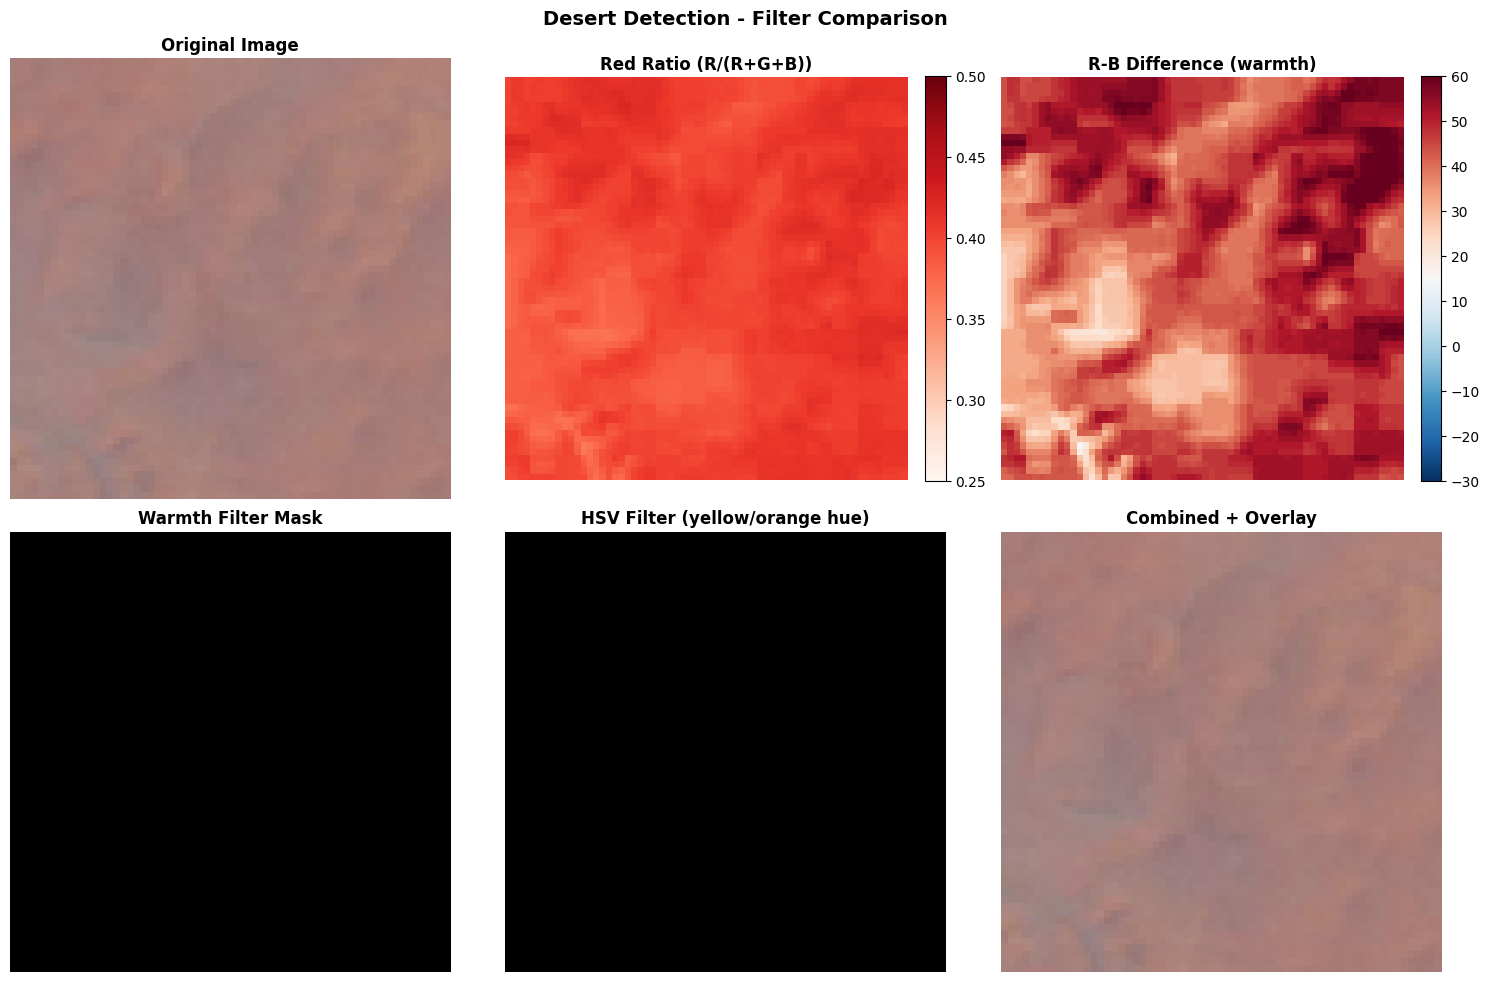

In [24]:
# Load desert samples
desert_samples = load_sample_images('desert', n_samples=5)
print(f"Loaded {len(desert_samples)} desert images")

# Test filter on first desert image
test_img = desert_samples[0]
print(f"\nTesting on desert image, shape: {test_img.shape}")

# Compare different filters
visualize_filter_comparison(test_img)

Testing desert detection on multiple desert images:


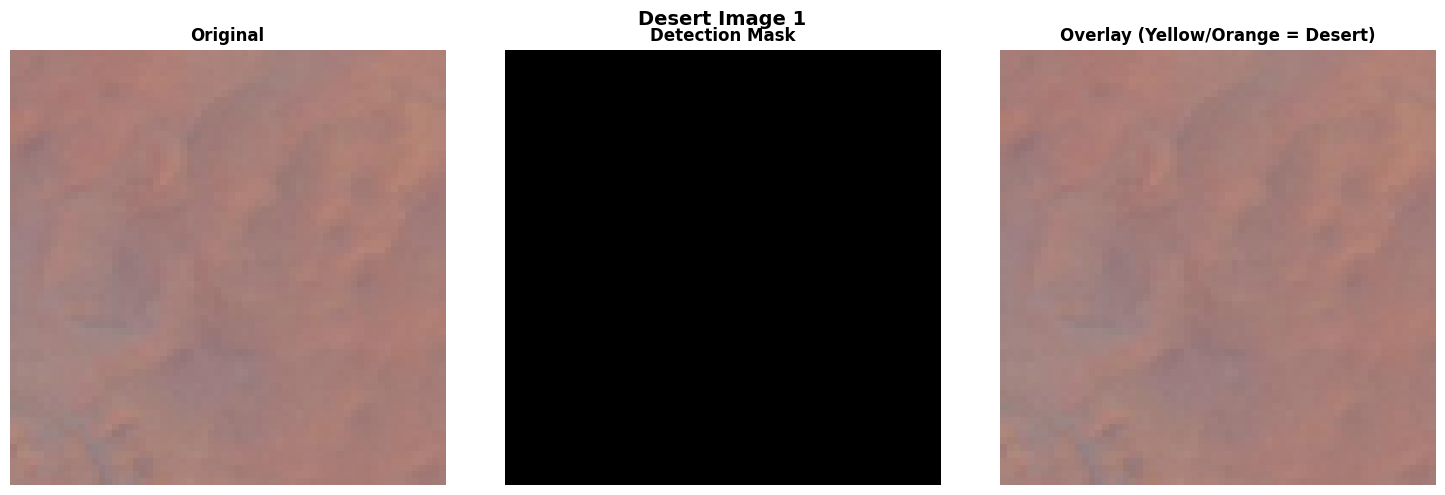

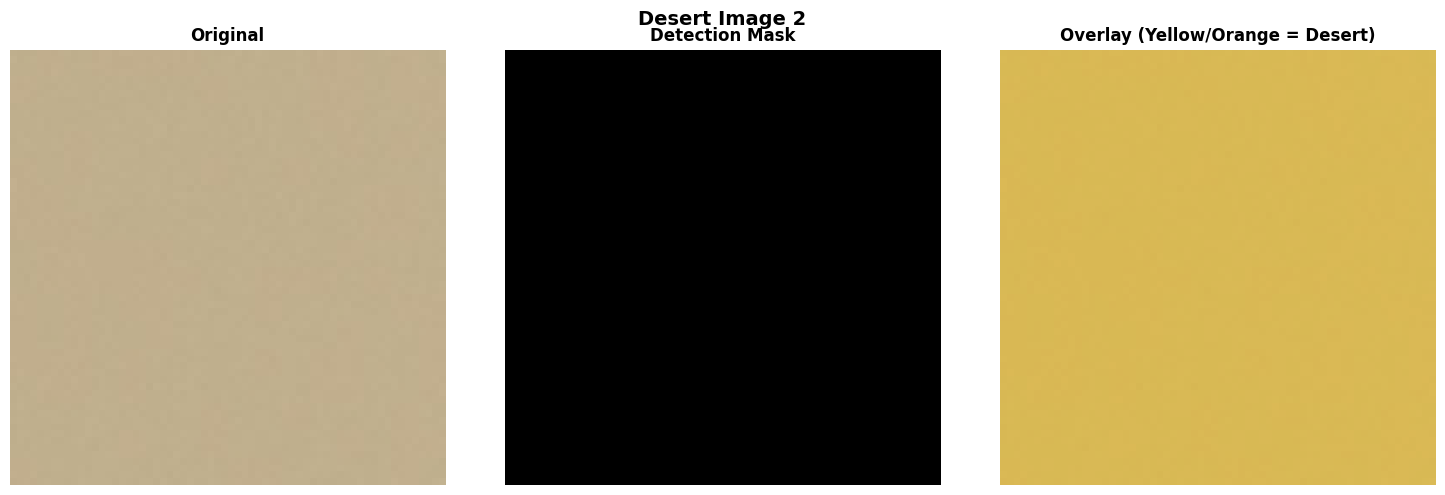

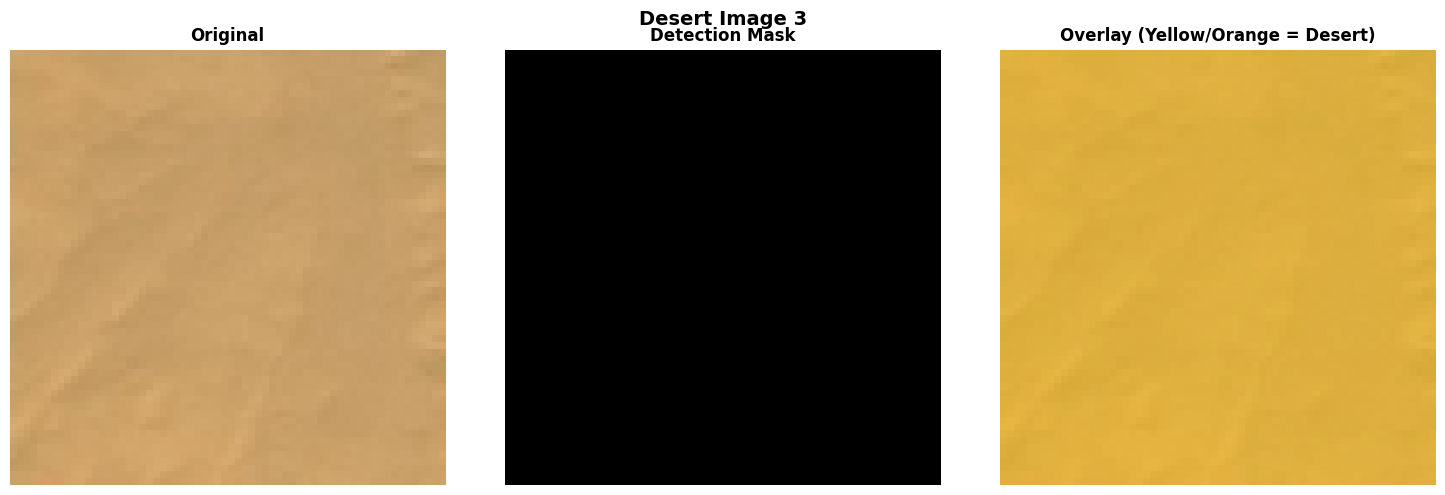

In [25]:
# Test on multiple desert images
print("Testing desert detection on multiple desert images:")
for i, img in enumerate(desert_samples[:3]):
    mask = detect_desert_combined(img)
    visualize_detection(img, mask, title=f"Desert Image {i+1}")

### 6.2 Test on Non-Desert Images (Control)

Testing desert detection on NON-desert images:
(Should detect minimal or no desert)

--- Cloudy ---


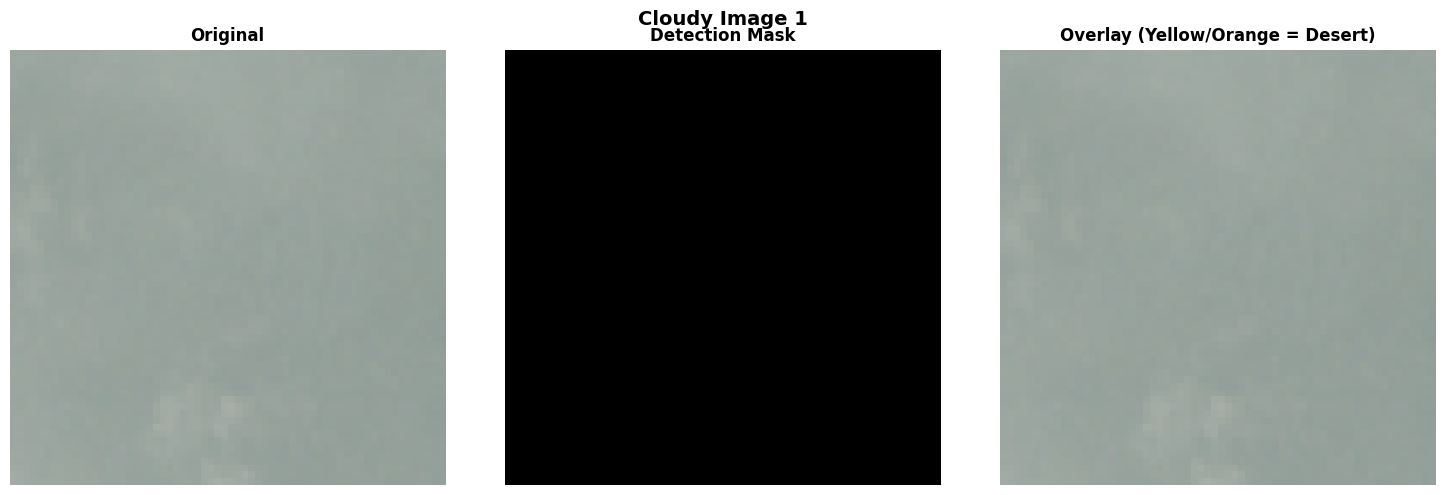

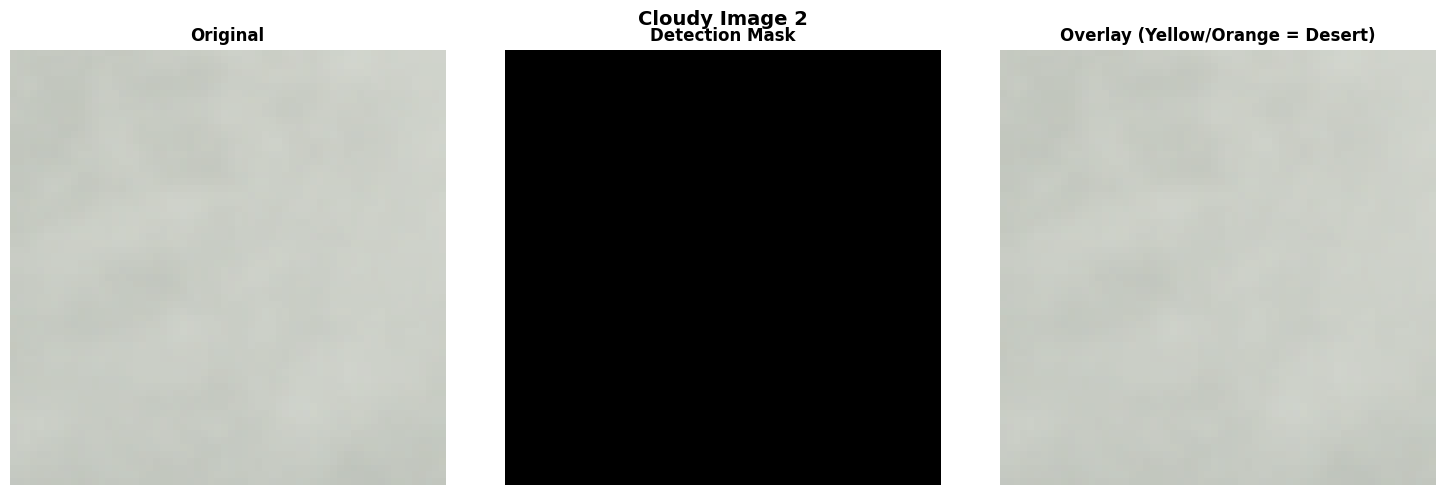

--- Vegetation ---


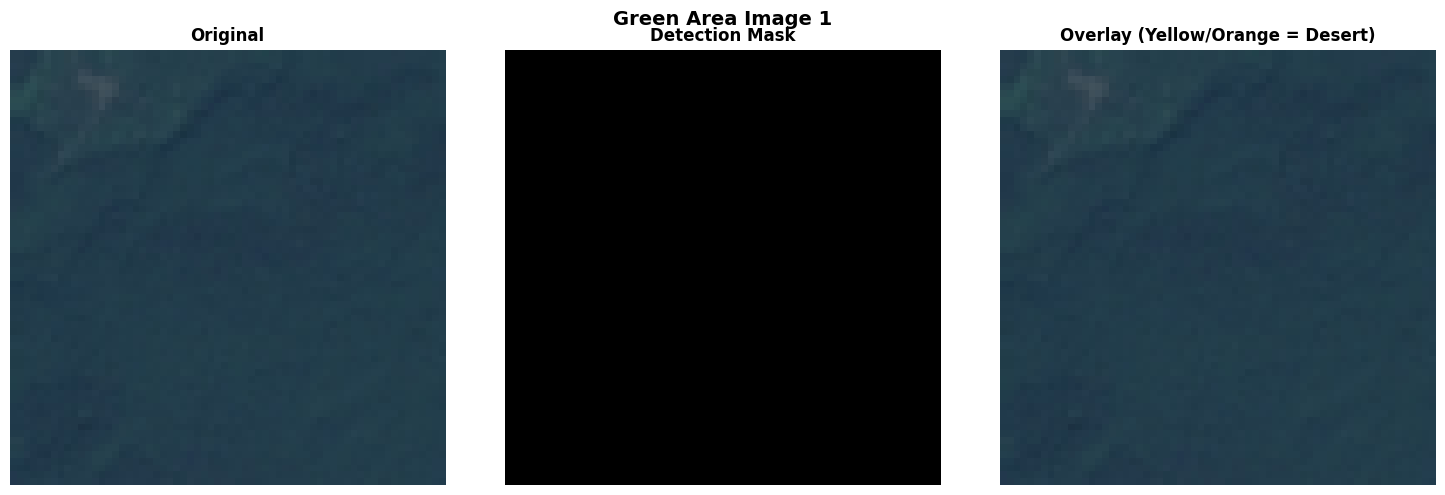

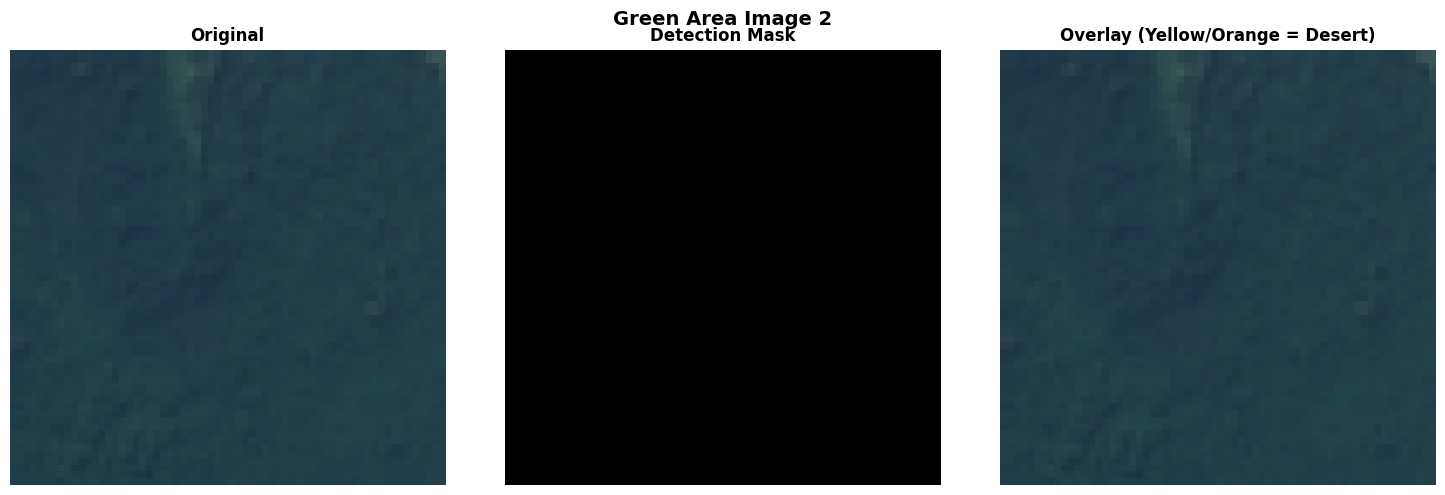

--- Water ---


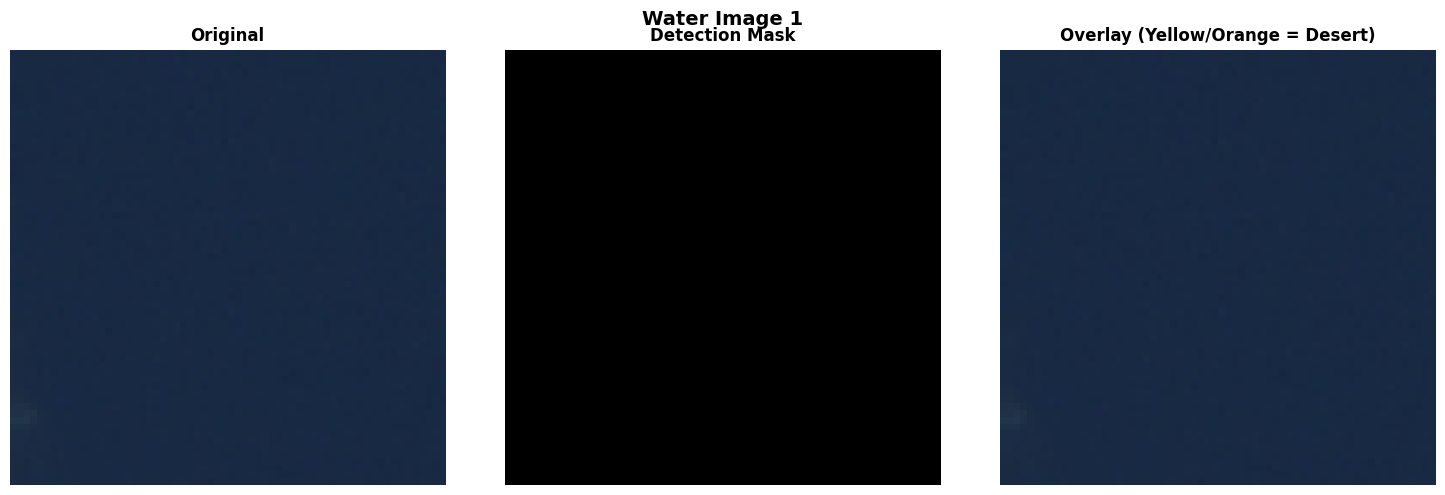

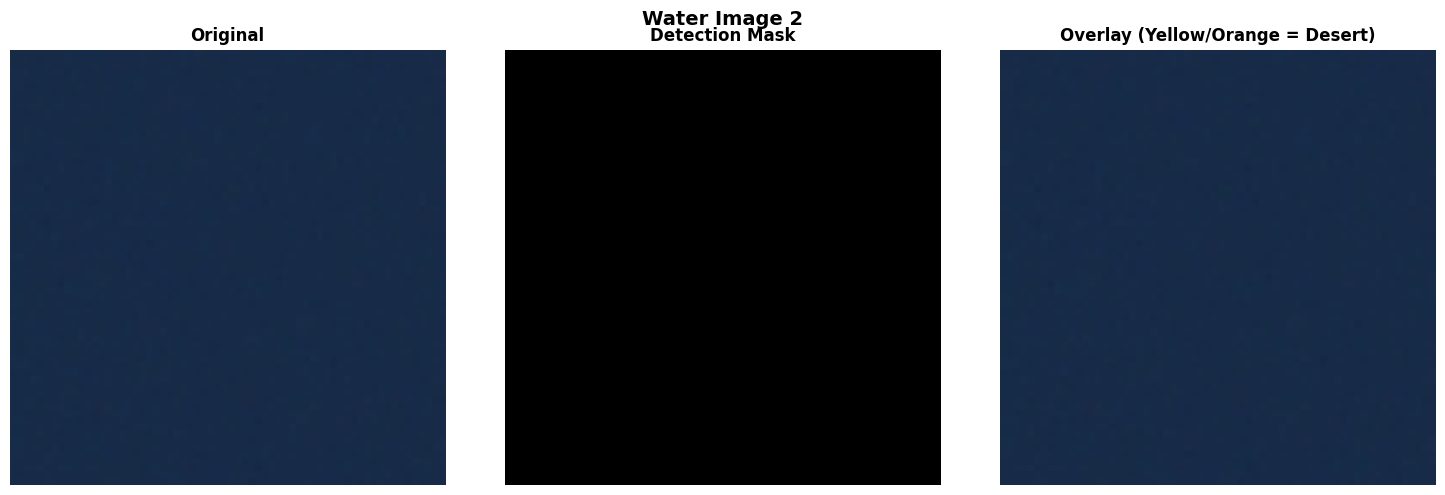

In [26]:
# Load samples from other categories
cloudy_samples = load_sample_images('cloudy', n_samples=2)
green_samples = load_sample_images('green_area', n_samples=2)
water_samples = load_sample_images('water', n_samples=2)

print("Testing desert detection on NON-desert images:")
print("(Should detect minimal or no desert)\n")

# Test cloudy
print("--- Cloudy ---")
for i, img in enumerate(cloudy_samples):
    mask = detect_desert_combined(img)
    visualize_detection(img, mask, title=f"Cloudy Image {i+1}")

# Test vegetation
print("--- Vegetation ---")
for i, img in enumerate(green_samples):
    mask = detect_desert_combined(img)
    visualize_detection(img, mask, title=f"Green Area Image {i+1}")

# Test water
print("--- Water ---")
for i, img in enumerate(water_samples):
    mask = detect_desert_combined(img)
    visualize_detection(img, mask, title=f"Water Image {i+1}")

## 7. Quantitative Evaluation

In [27]:
def calculate_desert_coverage(mask: np.ndarray) -> float:
    """
    Calculate percentage of image covered by desert.
    
    Args:
        mask: Binary mask (H, W)
    
    Returns:
        Percentage (0-100)
    """
    total_pixels = mask.size
    desert_pixels = np.sum(mask > 0)
    return (desert_pixels / total_pixels) * 100


def evaluate_filter_on_category(category: str, n_samples: int = 20) -> dict:
    """
    Evaluate desert filter on a category and compute statistics.
    
    Returns:
        dict with mean, std, min, max desert coverage percentage
    """
    images = load_sample_images(category, n_samples)
    coverages = []
    
    for img in images:
        mask = detect_desert_combined(img)
        coverage = calculate_desert_coverage(mask)
        coverages.append(coverage)
    
    return {
        'mean': np.mean(coverages),
        'std': np.std(coverages),
        'min': np.min(coverages),
        'max': np.max(coverages)
    }


print("Evaluating desert detection across all categories...\n")

results = {}
for category in CATEGORIES:
    print(f"Processing {category}...")
    results[category] = evaluate_filter_on_category(category, n_samples=20)

print("\n" + "="*70)
print("DESERT COVERAGE STATISTICS (%)")
print("="*70)
for category in CATEGORIES:
    stats = results[category]
    print(f"\n{category.replace('_', ' ').title()}:")
    print(f"  Mean:   {stats['mean']:.2f}%")
    print(f"  Std:    {stats['std']:.2f}%")
    print(f"  Range:  {stats['min']:.2f}% - {stats['max']:.2f}%")

print("\n" + "="*70)
print("Expected: Desert images should have HIGH coverage (>50%)")
print("          Other categories should have LOW coverage (<20%)")
print("="*70)

Evaluating desert detection across all categories...

Processing cloudy...
Processing desert...
Processing green_area...
Processing water...

DESERT COVERAGE STATISTICS (%)

Cloudy:
  Mean:   1.12%
  Std:    3.96%
  Range:  0.00% - 17.97%

Desert:
  Mean:   70.04%
  Std:    45.76%
  Range:  0.00% - 100.00%

Green Area:
  Mean:   0.00%
  Std:    0.00%
  Range:  0.00% - 0.00%

Water:
  Mean:   0.00%
  Std:    0.00%
  Range:  0.00% - 0.00%

Expected: Desert images should have HIGH coverage (>50%)
          Other categories should have LOW coverage (<20%)


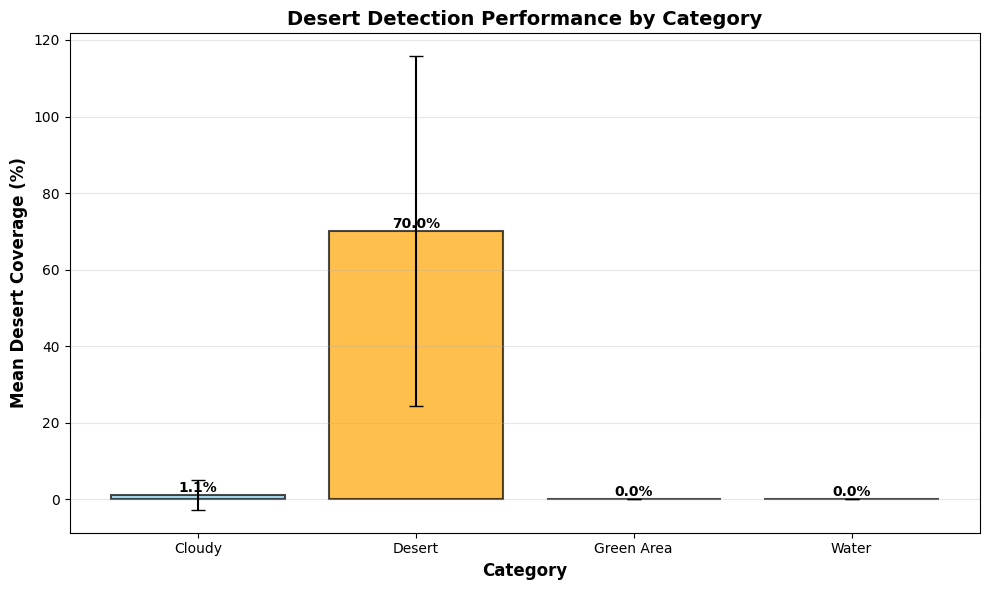

In [28]:
# Visualize results as bar chart
categories_labels = [cat.replace('_', ' ').title() for cat in CATEGORIES]
means = [results[cat]['mean'] for cat in CATEGORIES]
stds = [results[cat]['std'] for cat in CATEGORIES]

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(categories_labels))
bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, 
              color=['skyblue', 'orange', 'green', 'cyan'],
              edgecolor='black', linewidth=1.5)

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Desert Coverage (%)', fontsize=12, fontweight='bold')
ax.set_title('Desert Detection Performance by Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories_labels)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Parameter Tuning (Optional)

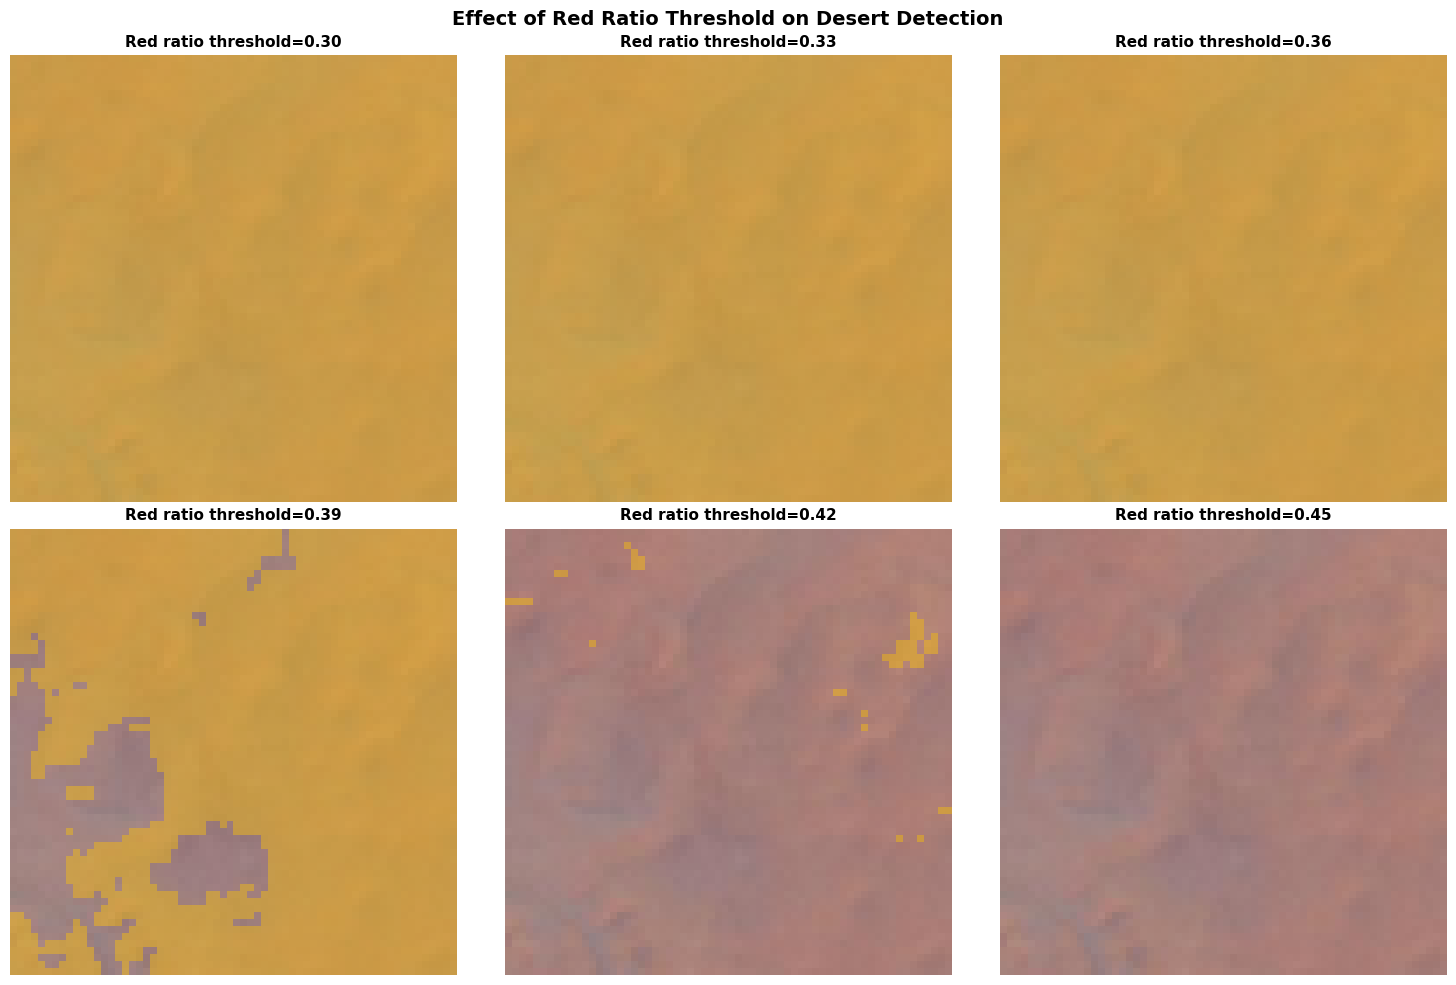

In [29]:
# Experiment with different red ratio thresholds
test_img = desert_samples[0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ratio_thresholds = [0.30, 0.33, 0.36, 0.39, 0.42, 0.45]

for idx, threshold in enumerate(ratio_thresholds):
    row = idx // 3
    col = idx % 3
    
    mask = detect_desert_warmth(test_img, red_ratio_threshold=threshold)
    overlay = apply_colored_overlay(test_img, mask)
    
    axes[row, col].imshow(overlay)
    axes[row, col].set_title(f'Red ratio threshold={threshold:.2f}', fontsize=11, fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('Effect of Red Ratio Threshold on Desert Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

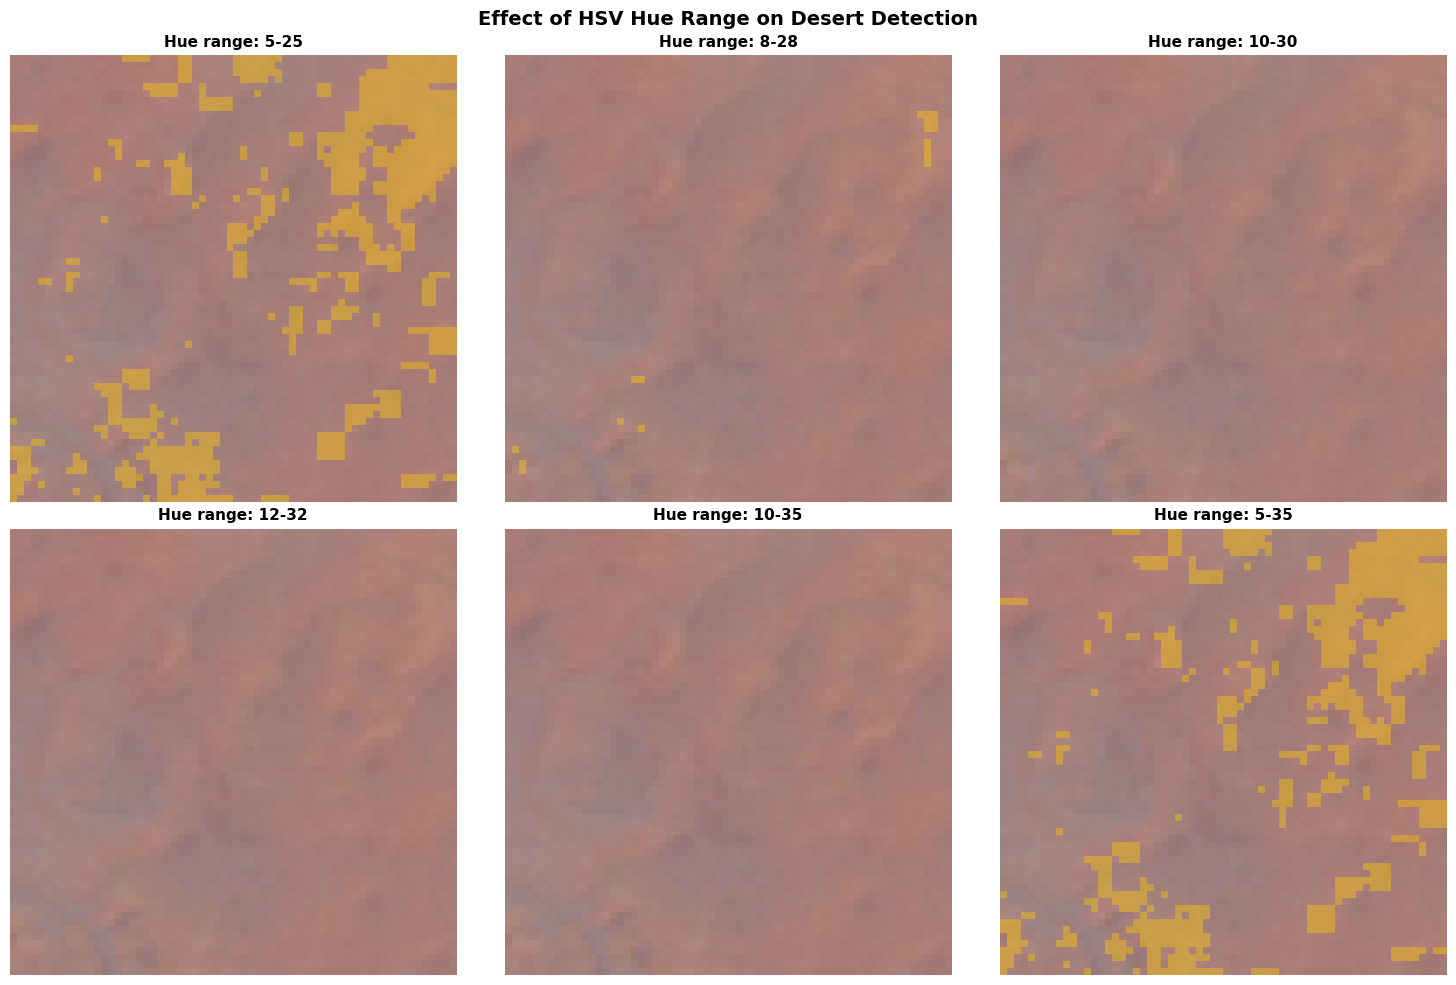

In [30]:
# Experiment with different HSV hue ranges
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Different yellow/orange hue ranges (min, max)
hue_ranges = [
    (5, 25),
    (8, 28),
    (10, 30),
    (12, 32),
    (10, 35),
    (5, 35)
]

for idx, (hue_min, hue_max) in enumerate(hue_ranges):
    row = idx // 3
    col = idx % 3
    
    mask = detect_desert_hsv(test_img, hue_min=hue_min, hue_max=hue_max)
    overlay = apply_colored_overlay(test_img, mask)
    
    axes[row, col].imshow(overlay)
    axes[row, col].set_title(f'Hue range: {hue_min}-{hue_max}', fontsize=11, fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('Effect of HSV Hue Range on Desert Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Analysis of Warmth Indices Across Categories

In [31]:
# Compare warmth characteristics across all categories
print("Analyzing warmth indices across categories...\n")

warmth_stats = {}

for category in CATEGORIES:
    images = load_sample_images(category, n_samples=20)
    
    red_ratios = []
    rb_diffs = []
    
    for img in images:
        red_ratio, rb_diff = calculate_warmth_indices(img)
        red_ratios.append(np.mean(red_ratio))
        rb_diffs.append(np.mean(rb_diff))
    
    warmth_stats[category] = {
        'red_ratio_mean': np.mean(red_ratios),
        'red_ratio_std': np.std(red_ratios),
        'rb_diff_mean': np.mean(rb_diffs),
        'rb_diff_std': np.std(rb_diffs)
    }

print("="*70)
print("WARMTH INDICES BY CATEGORY")
print("="*70)
for category in CATEGORIES:
    stats = warmth_stats[category]
    print(f"\n{category.replace('_', ' ').title()}:")
    print(f"  Red Ratio (R/(R+G+B)):  {stats['red_ratio_mean']:.3f} ± {stats['red_ratio_std']:.3f}")
    print(f"  R-B Difference:         {stats['rb_diff_mean']:.2f} ± {stats['rb_diff_std']:.2f}")

print("\n" + "="*70)
print("Expected: Desert should have highest red ratio and R-B difference")
print("          Water should have lowest (negative R-B difference)")
print("="*70)

Analyzing warmth indices across categories...

WARMTH INDICES BY CATEGORY

Cloudy:
  Red Ratio (R/(R+G+B)):  0.341 ± 0.013
  R-B Difference:         10.39 ± 8.57

Desert:
  Red Ratio (R/(R+G+B)):  0.384 ± 0.025
  R-B Difference:         45.21 ± 22.39

Green Area:
  Red Ratio (R/(R+G+B)):  0.214 ± 0.008
  R-B Difference:         -36.11 ± 4.14

Water:
  Red Ratio (R/(R+G+B)):  0.213 ± 0.043
  R-B Difference:         -41.71 ± 8.39

Expected: Desert should have highest red ratio and R-B difference
          Water should have lowest (negative R-B difference)


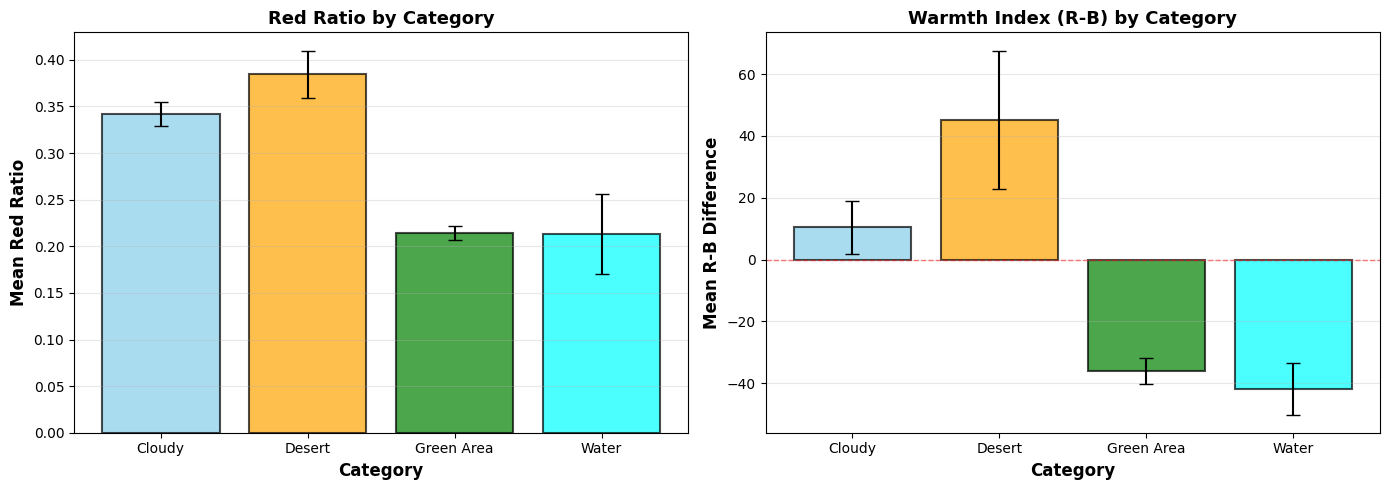

In [32]:
# Visualize warmth indices comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

categories_labels = [cat.replace('_', ' ').title() for cat in CATEGORIES]
x = np.arange(len(categories_labels))

# Red ratio comparison
red_ratio_means = [warmth_stats[cat]['red_ratio_mean'] for cat in CATEGORIES]
red_ratio_stds = [warmth_stats[cat]['red_ratio_std'] for cat in CATEGORIES]

axes[0].bar(x, red_ratio_means, yerr=red_ratio_stds, capsize=5, alpha=0.7,
            color=['skyblue', 'orange', 'green', 'cyan'],
            edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Category', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Mean Red Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('Red Ratio by Category', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories_labels)
axes[0].grid(True, alpha=0.3, axis='y')

# R-B difference comparison
rb_diff_means = [warmth_stats[cat]['rb_diff_mean'] for cat in CATEGORIES]
rb_diff_stds = [warmth_stats[cat]['rb_diff_std'] for cat in CATEGORIES]

axes[1].bar(x, rb_diff_means, yerr=rb_diff_stds, capsize=5, alpha=0.7,
            color=['skyblue', 'orange', 'green', 'cyan'],
            edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Category', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mean R-B Difference', fontsize=12, fontweight='bold')
axes[1].set_title('Warmth Index (R-B) by Category', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories_labels)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

## 10. Summary

In [33]:
print("\n" + "="*70)
print("DESERT DETECTION FILTER - SUMMARY")
print("="*70)

print("\nFilters Implemented:")
print("  1. Warmth Filter: Red Ratio R/(R+G+B) >= 0.36 AND R-B >= 15")
print("  2. HSV Filter: Yellow/orange hue (10-30°) + saturation & value constraints")
print("  3. Combined: Warmth AND HSV (conservative) + morphological cleaning")

print("\nKey Warmth Indices:")
print("  - Red Ratio: R/(R+G+B) → measures red dominance")
print("  - R-B Difference: R - B → separates warm (positive) from cool (negative)")

print("\nVisualization:")
print("  - Overlay color: Yellow-orange (255, 200, 0)")
print("  - Side-by-side: Original | Mask | Overlay")
print("  - Warmth heatmaps: Red ratio + R-B difference")

print("\nPerformance on test samples:")
for category in CATEGORIES:
    stats = results[category]
    print(f"  - {category.replace('_', ' ').title()}: {stats['mean']:.1f}% ± {stats['std']:.1f}%")

print("\nWarmth Index Analysis:")
for category in CATEGORIES:
    ws = warmth_stats[category]
    print(f"  - {category.replace('_', ' ').title()}: "
          f"Red Ratio={ws['red_ratio_mean']:.3f}, R-B={ws['rb_diff_mean']:.1f}")

print("\nKey Insights:")
if results['desert']['mean'] > 50:
    print("  ✓ Successfully detects desert in desert images (>50% coverage)")
else:
    print("  ⚠ Low detection in desert images - consider tuning thresholds")

non_desert_avg = np.mean([results[cat]['mean'] for cat in ['cloudy', 'green_area', 'water']])
if non_desert_avg < 20:
    print("  ✓ Low false positives in non-desert images (<20% average)")
else:
    print("  ⚠ High false positives - consider stricter thresholds")

if warmth_stats['desert']['red_ratio_mean'] > warmth_stats['water']['red_ratio_mean']:
    print("  ✓ Clear warmth separation between desert (warm) and water (cool)")

print("\n" + "="*70)
print("✓ Desert detection filter completed")
print("  Next step: Temperature proxy (05_temperature_proxy.ipynb)")
print("="*70)


DESERT DETECTION FILTER - SUMMARY

Filters Implemented:
  1. Warmth Filter: Red Ratio R/(R+G+B) >= 0.36 AND R-B >= 15
  2. HSV Filter: Yellow/orange hue (10-30°) + saturation & value constraints
  3. Combined: Warmth AND HSV (conservative) + morphological cleaning

Key Warmth Indices:
  - Red Ratio: R/(R+G+B) → measures red dominance
  - R-B Difference: R - B → separates warm (positive) from cool (negative)

Visualization:
  - Overlay color: Yellow-orange (255, 200, 0)
  - Side-by-side: Original | Mask | Overlay
  - Warmth heatmaps: Red ratio + R-B difference

Performance on test samples:
  - Cloudy: 1.1% ± 4.0%
  - Desert: 70.0% ± 45.8%
  - Green Area: 0.0% ± 0.0%
  - Water: 0.0% ± 0.0%

Warmth Index Analysis:
  - Cloudy: Red Ratio=0.341, R-B=10.4
  - Desert: Red Ratio=0.384, R-B=45.2
  - Green Area: Red Ratio=0.214, R-B=-36.1
  - Water: Red Ratio=0.213, R-B=-41.7

Key Insights:
  ✓ Successfully detects desert in desert images (>50% coverage)
  ✓ Low false positives in non-desert ima